# Pearson correlation coefficient inference
The Pearson correlation coefficient is very sensitive to serial correlation in the series being correlated. In the multi-year verification literature, it is very common to quantify the skill of ensemble-mean, multi-year-rolling-mean quantities using the Pearson anomaly cross correlation. The averaging (ensemble and temporal) results in substantial serial correlation in the signals being correlated. Thus, commonly applied statistical tests used to infer significance may not be appropriate.

In [1]:
import regionmask

import numpy as np

import xarray as xr

import xskillscore as xs

import matplotlib.pyplot as plt

from src import utils, plot, verify

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.arima_process import ArmaProcess

/datasets/work/oa-dcfp/work/squ027/.conda/envs/forecast_analysis/lib/python3.9/site-packages/pyproj/__init__.py:89: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()


In [2]:
%load_ext autoreload
%autoreload 2
%load_ext lab_black

In [3]:
DATA_DIR = "../../data/"

## Let's try to demonstrate the issue

We'll use the CanESM5 CMIP6 DCPP hindcast precipitation dataset as an example

In [4]:
var_name = "precip"
verif_period = ["1969", "2018"]

In [5]:
hcst_raw = xr.open_zarr(
    f"{DATA_DIR}/processed/CanESM5.annual.anom_1985-2014.precip_global.zarr"
)
ctrl_raw = xr.open_zarr(
    f"{DATA_DIR}/processed/CanESM5_ctrl.annual.anom_6571-6600.precip_global.zarr"
)

### Focus on the Australian Giorgi and Franciso [2000] region

In [6]:
regions = regionmask.defined_regions.giorgi.mask(hcst_raw)
region_indices = regionmask.defined_regions.giorgi.map_keys(["Australia"])
mask = regions.isin(region_indices)

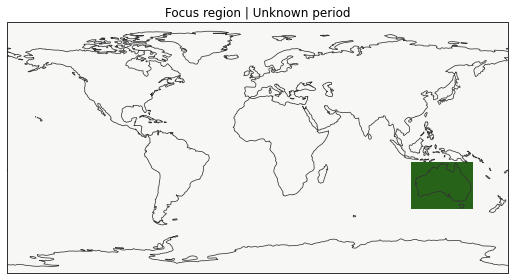

In [7]:
_ = plot.metric_maps(
    [[mask.to_dataset(name="mask")]],
    "mask",
    vrange=(0, 1),
    headings=[["Focus region"]],
    add_colorbar=False,
    central_longitude=0,
    figsize=(8, 4),
)

In [8]:
def weighted_average(ds):
    """Return area weighted average over all lon and lat"""
    return ds.weighted(ds.area).mean(["lon", "lat"])

In [9]:
hcst_region = weighted_average(hcst_raw.where(mask)).compute()
ctrl_region = weighted_average(ctrl_raw.where(mask)).compute()

### And on 1-, 2-, 4- and 8-year averages

In [10]:
def get_lead(ds, lead):
    """Return a specified lead of a hindcast dataset, indexed against time"""
    return ds.sel(lead=lead).swap_dims({"init": "time"})

In [11]:
hcst = {"1-year": get_lead(hcst_region, 12 + 11).sel(time=slice(*verif_period))}
ctrl = {"1-year": ctrl_region}

average = [2, 4, 8]
for av in average:
    hcst[f"{av}-year"] = get_lead(
        utils.rolling_mean(hcst_region, window_size=av, dim="lead"), (av) * 12 + 11
    ).sel(time=slice(*verif_period))
    ctrl[f"{av}-year"] = utils.rolling_mean(
        ctrl_region, window_size=av, dim="time"
    ).dropna("time")

### Get some observations

In [100]:
nsamples = 100_000
ar = np.array([1, -0.24, 0.16])

arma_process = ArmaProcess(ar)
times = get_lead(hcst_region, 12 + 11).time
s = arma_process.generate_sample(nsample=nsamples * len(times))
s = xr.DataArray(
    np.reshape(s, (nsamples, len(times))),
    coords={"sample": range(nsamples), "time": times},
).to_dataset(name=var_name)

obsv = {"1-year": s.sel(time=slice(*verif_period))}

average = [2, 4, 8]
for av in average:
    obsv[f"{av}-year"] = utils.rolling_mean(s, window_size=av, dim="time").sel(
        time=slice(*verif_period)
    )

### Let's correlate the ensemble mean hindcasts and observations over the 50-year verification period

In [101]:
def pearsonr_scipy(a, b, dim="time"):
    """Return correlations and p-values from scipy.stats.pearsonr"""
    import scipy.stats as ss

    def _pearsonr(a, b):
        return ss.pearsonr(a, b)

    return xr.apply_ufunc(
        _pearsonr,
        a,
        b,
        input_core_dims=[[dim], [dim]],
        output_core_dims=[[], []],
        vectorize=True,
    )


def pearsonr_bs(a, b, return_iterations=False, blocksize=5):
    """Return correlation and p-values from block bootstrap procedure"""
    r = verify.rXY(a, b)

    r_bs = verify.rXY(
        *verify.iterative_blocked_bootstrap(
            a,
            b,
            blocks={"time": blocksize, "member": 1},
            n_iterations=100_000,
        )
    )

    if return_iterations:
        return r, r_bs
    else:
        r_trans = verify.Fisher_z(r)
        r_bs_trans = verify.Fisher_z(r_bs)

        left_p = xr.where(r_bs_trans < 0, 1, 0).mean("iteration")
        right_p = xr.where(r_bs_trans > 0, 1, 0).mean("iteration")
        p = xr.where(r_trans >= 0, left_p, right_p) * 2

        return r, p

In [109]:
r, p = pearsonr_scipy(hcst["8-year"][var_name].mean("member"), obsv["8-year"][var_name])
target_p = 1e-3
ind_example = abs(p.where(r > 0) - target_p).argmin("sample").values
r_example = r.isel(sample=ind_example)
p_example = p.isel(sample=ind_example)

obsv_example = {t: o.isel(sample=ind_example) for t, o in obsv.items()}

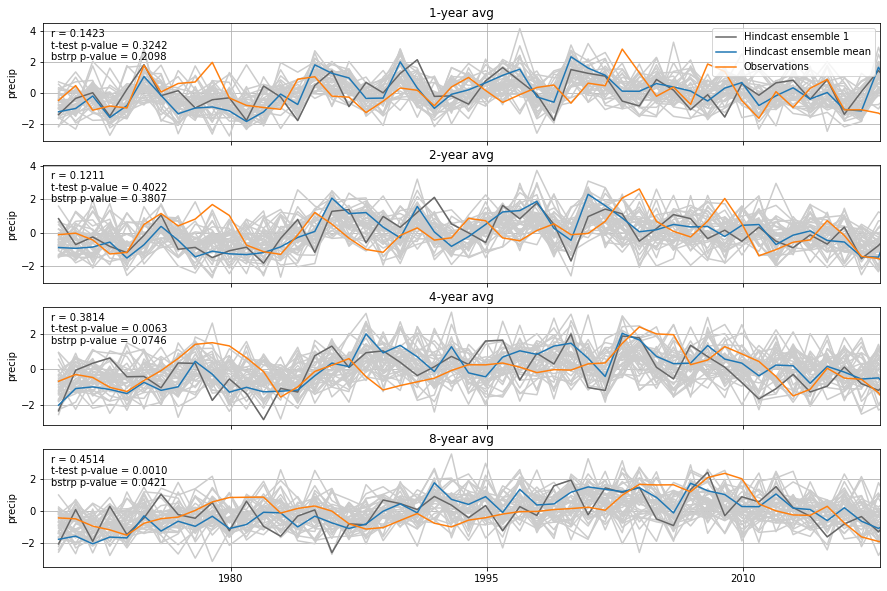

In [110]:
fig = plt.figure(figsize=(15, 10))
axs = fig.subplots(len(hcst), 1, sharex=True)

for ax, t in zip(axs, hcst.keys()):
    h = hcst[t] - hcst[t].mean()
    o = obsv_example[t] - obsv_example[t].mean()

    h_mem = (h / h.std(["member", "time"]))[var_name]
    h_mem.plot.line(
        ax=ax, x="time", label="__nolabel__", color=[0.8, 0.8, 0.8], add_legend=False
    )
    h_mem.sel(member=1).plot(ax=ax, label="Hindcast ensemble 1", color=[0.4, 0.4, 0.4])

    h_mean = (h.mean("member") / h.mean("member").std("time"))[var_name]
    h_mean.plot(ax=ax, label="Hindcast ensemble mean", color="C0")

    o_norm = (o / o.std("time"))[var_name]
    o_norm.plot(ax=ax, color="C1", label="Observations")

    r, p = pearsonr_scipy(h_mean, o_norm)
    _, p_bs = pearsonr_bs(h, o)

    ax.text(
        0.01,
        0.95,
        (
            f"r = {r.values:.4f}\n"
            f"t-test p-value = {p.values:.4f}\n"
            f"bstrp p-value = {p_bs[var_name].values:.4f}"
        ),
        va="top",
        transform=ax.transAxes,
    )

    ax.grid()
    ax.set_title(f"{t} avg")
    ax.set_xlabel("")
    ax.set_xlim(
        xr.cftime_range(
            *verif_period,
            periods=2,
            freq=None,
            calendar=o.time.dt.calendar,
        )
    )

_ = axs[0].legend(loc="upper right")

### Autocorrelation functions

In [111]:
def acf(ds, dim="time", nlags=20):
    """Vectorized statsmodels.api.tsa.acf for xarray objects"""
    import statsmodels.api as sm

    def _acf(data, nlags):
        return sm.tsa.acf(data, nlags=nlags)

    return xr.apply_ufunc(
        _acf,
        ds,
        kwargs=dict(
            nlags=nlags,
        ),
        input_core_dims=[[dim]],
        output_core_dims=[["lag"]],
        vectorize=True,
    ).assign_coords({"lag": range(nlags + 1)})

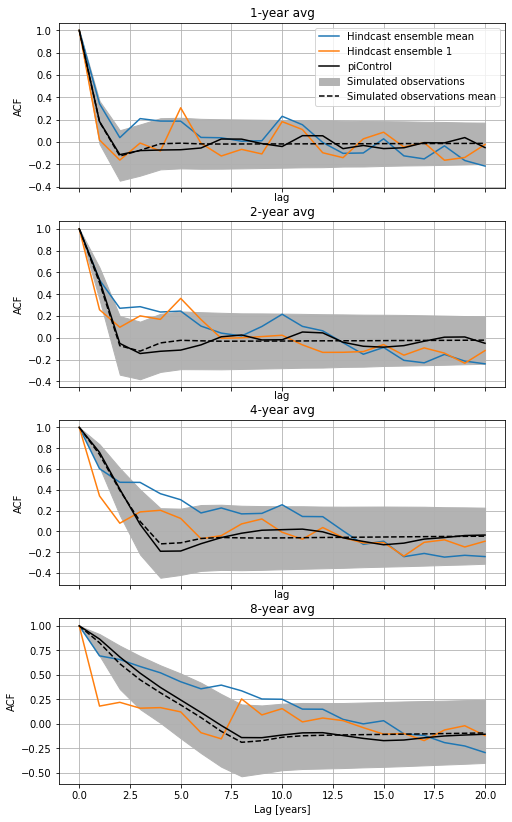

In [112]:
fig = plt.figure(figsize=(8, 14))
axs = fig.subplots(len(hcst), 1, sharex=True)

for ax, t in zip(axs, hcst.keys()):
    h = hcst[t][var_name]
    c = ctrl[t][var_name]
    o = obsv[t][var_name]

    h_acf_mean = acf(h.mean("member"))
    h_acf_mem = acf(h.sel(member=1))
    c_acf = acf(c)
    o_acf = acf(o)

    h_acf_mean.plot(ax=ax, label="Hindcast ensemble mean")
    h_acf_mem.plot(ax=ax, label="Hindcast ensemble 1")
    c_acf.plot(ax=ax, color="k", label="piControl")
    ax.fill_between(
        o_acf.lag,
        o_acf.quantile(q=0.05, dim="sample"),
        o_acf.quantile(q=0.95, dim="sample"),
        label="Simulated observations",
        color=[0.7, 0.7, 0.7],
    )
    o_acf.mean("sample").plot(
        ax=ax, color="k", linestyle="--", label="Simulated observations mean"
    )

    ax.grid()
    ax.set_title(f"{t} avg")
    ax.set_ylabel("ACF")

    if t == "8-year":
        ax.set_xlabel("Lag [years]")

axs[0].legend()

### What is the p-value esimated from the null distribution?

Let's estimate the null distribution using our simulated observations

In [113]:
def student_t(N):
    """Return Student-t distribution for null correlation"""
    from scipy.stats import beta

    a = N / 2 - 1
    b = N / 2 - 1
    return beta(a, b, loc=-1, scale=2)

In [114]:
def Wilks_blocksize(n, n_eff):
    """Return the block size to use for lock boostrapping according to Wilks, pg 191"""
    from scipy.optimize import fsolve

    def f(L, n, n_eff):
        return (n - L + 1) ** ((2 / 3) * (1 - (n_eff / n))) - L

    return round(fsolve(f, 5, args=(n, n_eff))[0])

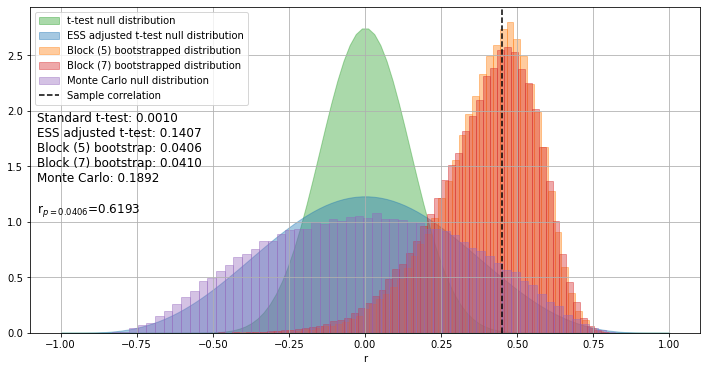

In [115]:
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111)

# t-test
t_dist = student_t(50)
x = np.linspace(-1, 1, 100)
ax.fill_between(
    x, t_dist.pdf(x), color="C2", alpha=0.4, label="t-test null distribution"
)
p_t = 2 * t_dist.cdf(-abs(r_example))

# t-test effective sample size
ess = int(
    xs.effective_sample_size(
        hcst["8-year"][var_name].mean("member"), obsv["8-year"][var_name]
    )
    .mean()
    .round()
)
t_dist = student_t(ess)
x = np.linspace(-1, 1, 100)
ax.fill_between(
    x,
    t_dist.pdf(x),
    color="C0",
    alpha=0.4,
    label="ESS adjusted t-test null distribution",
)
p_t_ess = 2 * t_dist.cdf(-abs(r_example))

# Bootstrap (block = 5)
r, bs = pearsonr_bs(hcst["8-year"], obsv_example["8-year"], return_iterations=True)
_, p_bs_5 = pearsonr_bs(hcst["8-year"], obsv_example["8-year"])
ax.hist(
    bs[var_name],
    60,
    density=True,
    facecolor="C1",
    edgecolor="C1",
    alpha=0.4,
    label="Block (5) bootstrapped distribution",
)

# Bootstrap (block from Wilks)
block = Wilks_blocksize(50, ess)
r, bs = pearsonr_bs(
    hcst["8-year"], obsv_example["8-year"], return_iterations=True, blocksize=block
)
_, p_bs_W = pearsonr_bs(hcst["8-year"], obsv_example["8-year"])
ax.hist(
    bs[var_name],
    60,
    density=True,
    facecolor="C3",
    edgecolor="C3",
    alpha=0.4,
    label=f"Block ({block}) bootstrapped distribution",
)

# Monte Carlo
MC_null = xs.pearson_r(hcst["8-year"].mean("member"), obsv["8-year"], dim="time")
ax.hist(
    MC_null[var_name],
    60,
    density=True,
    facecolor="C4",
    edgecolor="C4",
    alpha=0.4,
    label="Monte Carlo null distribution",
)
p_mc = 2 * (MC_null > r).mean()
p_crit = p_bs_5[var_name].values
r_crit = MC_null.quantile(1 - p_crit / 2, dim="sample")

ylim = ax.get_ylim()
ax.plot(
    [r[var_name], r[var_name]],
    ylim,
    color="k",
    linestyle="--",
    label="Sample correlation",
)
ax.set_ylim(ylim)

ax.legend()
ax.grid()
ax.set_xlabel("r")

_ = ax.text(
    0.01,
    0.68,
    (
        f"Standard t-test: {p_t:.4f}\n"
        f"ESS adjusted t-test: {p_t_ess:.4f}\n"
        f"Block (5) bootstrap: {p_bs_5[var_name].values:.4f}\n"
        f"Block ({block}) bootstrap: {p_bs_W[var_name].values:.4f}\n"
        f"Monte Carlo: {p_mc[var_name].values:.4f}\n\n"
        r"r$_{p=" + f"{p_crit:.4f}" + r"}$=" + f"{r_crit[var_name].values:.4f}"
    ),
    va="top",
    transform=ax.transAxes,
    fontsize=12,
)

### Is it valid to only scramble the obsv to generate the null distribution?

I don't think so

In [93]:
nsamples = 2_000_000
ar = np.array([1, -0.24, 0.16])

arma_process = ArmaProcess(ar)
times = get_lead(hcst_region, 12 + 11).time
s = arma_process.generate_sample(nsample=nsamples * len(times))
s = xr.DataArray(
    np.reshape(s, (nsamples, len(times))),
    coords={"sample": range(nsamples), "time": times},
).to_dataset(name=var_name)

test = {"1-year": s.sel(time=slice(*verif_period))}

average = [2, 4, 8]
for av in average:
    test[f"{av}-year"] = utils.rolling_mean(s, window_size=av, dim="time").sel(
        time=slice(*verif_period)
    )

In [94]:
t1 = {t: v.isel(sample=range(int(nsamples / 2))) for t, v in test.items()}
t2 = {
    t: v.isel(sample=range(int(nsamples / 2), nsamples)).assign_coords(
        {"sample": t1[t].sample}
    )
    for t, v in test.items()
}

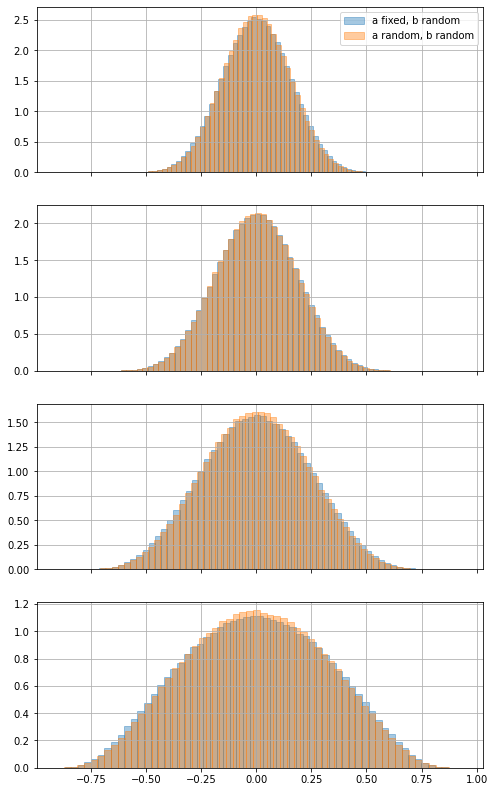

In [97]:
fig = plt.figure(figsize=(8, 14))
axs = fig.subplots(len(t1), 1, sharex=True)

for i, t in enumerate(t1.keys()):
    axs[i].hist(
        xs.pearson_r(t1[t].isel(sample=10, drop=True), t2[t], dim="time")[var_name],
        60,
        density=True,
        facecolor="C0",
        edgecolor="C0",
        alpha=0.4,
        label="a fixed, b random",
    )
    axs[i].hist(
        xs.pearson_r(t1[t], t2[t], dim="time")[var_name],
        60,
        density=True,
        facecolor="C1",
        edgecolor="C1",
        alpha=0.4,
        label="a random, b random",
    )

    axs[i].grid()

axs[0].legend()